In [108]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import pandas as pd
import os
import emcee
import corner
from getdist import plots, gaussian_mixtures, MCSamples
import time

# SNe Ia Data

In [109]:
os.listdir()
os.listdir('Pantheon_SNeIa_dataset/')

['lcparam_DS17f.txt']

In [110]:
#binned Pantheon SNe Ia data
full_data = pd.read_csv('Pantheon_SNeIa_dataset/lcparam_DS17f.txt',sep=' ')

redshift = full_data['zcmb']
appmag = full_data['mb']
appmag_unc = full_data['dmb']

#absolute magnitude for Type 1a SNe
absmag = -19.25

#distance modulus = m - M
distmod = appmag - absmag
distmod.shape
distmod_unc = appmag_unc

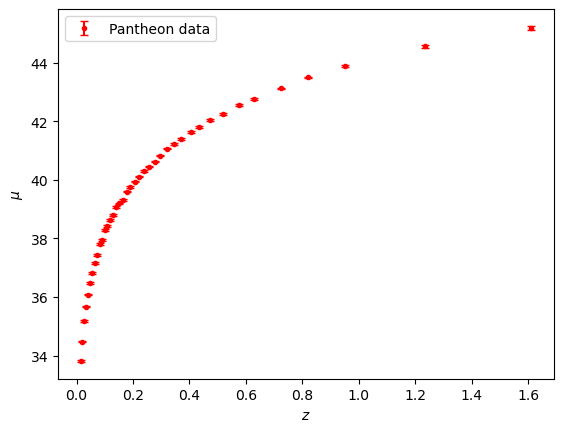

In [111]:
plt.figure()
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

# CC Data

In [112]:
os.listdir()
os.listdir('CC_dataset/')

['CC_data.xlsx']

In [113]:
#CC data
full_data_CC = pd.read_excel('CC_dataset/CC_data.xlsx')

redshift_CC = full_data_CC['redshift']
Hub = full_data_CC['H(z)']
Hub_unc = full_data_CC['sigma']

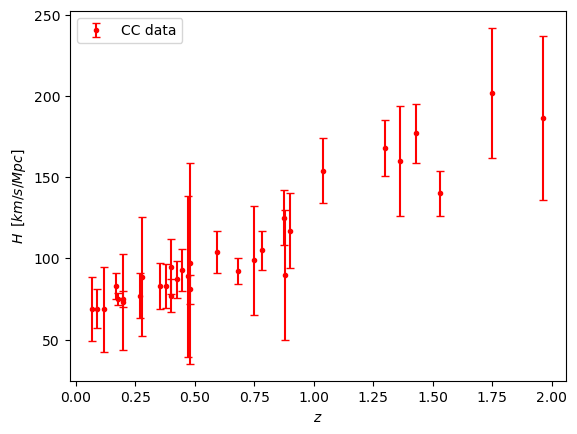

In [114]:
plt.figure()
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.xlabel('$z$')
plt.ylabel('$H\,\,\,[km/s/Mpc]$')
plt.legend()
plt.show()

# CMB Distance Priors

In [115]:
ls_av = 299792.458 #lightspeed in km/s
z_CMB = 1089

#data
R = 1.7661
la = 301.7293
v_obs = np.array([R,la])
#print(v_obs)

#covariance matrix
C = 10**(-8)*np.array([[33483.54, -44417.15],[-44417.15, 4245661.67]])
C_inv = np.linalg.inv(C)
#print(C_inv)

# BBN

In [116]:
#Our "data" is the hubble parameter for LambdaCDM at z=10^9
redshift_BBN = 10**9
H0_av = 67.4
HLCDM = H0_av*np.sqrt(5*10**(-5)*(1+redshift_BBN)**4)

# BAO

In [117]:
os.listdir()
os.listdir('BAO_dataset/')

['BAO_data.xlsx']

In [118]:
#BAO data
full_data_BAO = pd.read_excel('BAO_dataset/BAO_data.xlsx')

redshift_BAO = full_data_BAO['redshift']
Thetdeg = full_data_BAO['Theta [deg]']
Thetdeg_unc = full_data_BAO['sigma [deg]']

Thet = Thetdeg*np.pi/180 #change to radians
Thet_unc = Thetdeg_unc*np.pi/180 #change to radians

In [119]:
#Our observable with uncertainty
DA_rdrag = 1/((1+redshift_BAO)*Thet)
#DA_rdrag
DA_rdrag_unc = Thet_unc/((1+redshift_BAO)*Thet**2)
#DA_rdrag_unc

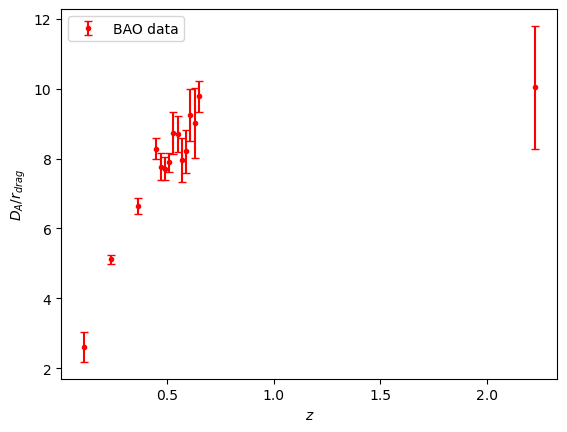

In [120]:
plt.figure()
plt.errorbar(redshift_BAO, DA_rdrag, yerr=DA_rdrag_unc, capsize=3, fmt='r.', label='BAO data')
plt.xlabel('$z$')
plt.ylabel('$D_A/r_{drag}$')
plt.legend()
plt.show()

# Numerical Solution

In [121]:
class AXIS_interval:
    
    def __init__(self, x_iv):
        self.m    = x_iv[2]+1
        self.x    = np.linspace(x_iv[0],x_iv[1],self.m)
        self.xrev = np.linspace(x_iv[1],x_iv[0],self.m)
        self.y    = np.zeros((3,self.m))
        self.ms   = 0
        self.me   = 0
        return


class AXIS:
    
    def __init__(self, x_iv):
        self.AXI = []
        #Input of xs,xe,n_sample per interval----------
        n = 0
        for i in range(len(x_iv)):
            self.AXI.append(AXIS_interval(x_iv[i]))
            self.AXI[i].ms = n
            n += self.AXI[i].m-1
            self.AXI[i].me = n
        self.niv = len(self.AXI)    #no. of intervals
        self.m = 0
        for i in range(self.niv):
            self.m += self.AXI[i].m
        self.m -= self.niv-1
        
        self.x = np.zeros(self.m)
        k = 0
        for i in range(self.niv):
            for j in range(self.AXI[i].m):
                self.x[k+j] = self.AXI[i].x[j]
            k += self.AXI[i].m-1
        return

        
    def get_index(self, xi):
        x = self.x
        m = self.m
        mx = 0
        if   xi <= x[0]:   mx = 0
        elif xi >= x[m-1]: mx = m-1
        else:
            for i in range(self.m):
                if x[i] > xi:
                    break
                mx = i
        return mx
    
    
    def get_interval(self, index):
        for i in range(self.niv):
            ms  = self.AXI[i].ms
            me1 = self.AXI[i].me+1
            for j in range(ms,me1):
                if index == j: return i
        return -1

In [122]:
def prepare_solving():
    # start values, y0[2] = s(1) will be calculated
    y0 = np.zeros(3)
    y0[0] =  1    # a(1)
    y0[1] =  1    # H(1)

    # t-axis
    t_iv = []
    '''
    t_iv.append([-0.3, 10**(-10), 100000])
    for i in range(-10,0):
        t_iv.append([10**i, 10**(i+1), 200])
    t_iv.append([1.0,   3.0,   200])
    '''
    t_iv.append([-0.5, 0.0, 200])
    t_iv.append([0.0,  1.0, 200])
    t_iv.append([1.0,  3.0, 200])

    AX = AXIS(t_iv)
        
    y    = np.zeros((3,AX.m))
    yp   = np.zeros(3)
    
    # z-axis
    zmin = 0
    zred = 2
    ns   = 200
    zmax = 170
    ncmb = 200
    zs   = np.linspace(zmin, zred, ns)
    zcmb = np.linspace(zred, zmax, ncmb)
    nt   = ns+ncmb-1
    zt   = np.zeros(nt)
    for i in range(nt):
        zt[i] = zs[i] if i <= ns-1 else zcmb[i-ns+1]
    
    di   = np.zeros(ns)
    Hz   = np.zeros(nt)
    mus  = np.zeros(ns)
    rcd  = np.zeros(nt)  #comoving distance
    mut  = np.zeros(nt)
    return AX, y0, y, yp, zs, di, mus, zt, Hz, rcd, mut

In [123]:
# Friedman equations, CCGG
def FL_equations_CG(x, y, yp, *args):
    Om   = args[0]
    Orad = args[1]
    Ol   = args[2]
    Ok   = args[3]
    Os   = args[5]
    Og   = args[6]
    
    err  = 0
    Os2  = Os/2
    a    = y[0]
    H    = y[1]
    s    = y[2] 

    if a > 1.e-20:
        a2 = a**2
        a3 = a**3
        H2 = H**2
        s2 = s**2
        M  = 0.25*Om/a3+Ol
        V0 = -Om/a-Orad/a2-Ol*a2
        yp[0] = a*H
        yp[1] = -2*H2+2*M+Ok/a2-(Os-1)*s2
        ks = (H2*s2-M*(3*Om/(a3*4)+Orad*a**(-4))
              +Os2*s2*(H2+(Os2-1)*s2-Ok/a2)
              +(Og-M)*(H2+V0/a2-Ok/a2+(Os-1)*s2))
        if ks < 1.e-12: err = 2
        else: yp[2] = -H*s+2*np.sqrt(ks)
    else:
        err = 1
    return yp, err

In [124]:
# Friedman equations, GR
def FL_equations_GR(x, y, yp, *args):
    Om   = args[0]
    Orad = args[1]
    Ol   = args[2]
    Ok   = args[3]

    err  = 0
    a    = y[0]
    H    = y[1]

    if a > 1.e-20:
        a2 = a**2
        a3 = a**3
        H2 = H**2
        M  = 0.25*Om/a3+Ol
        V0 = -Om/a-Orad/a2-Ol*a2
        yp[0] = a*H
        yp[1] = -2*H2+2*M+Ok/a2
    else:
        err = 1
    return yp, err

In [125]:
# 1st order Runge Kutta
def FO_RK4(f, x, y, yp, *args):
    m   = len(x)         
    h   = x[1]-x[0]
    h2  = h/2
    err  = 0
    nerr = -1
 
    for i in range(1, m):
        yh = y[:, i-1]
        k1, err1 = f(x[i-1],    yh,      yp, *args)
        k1 = k1*h
        k2, err2 = f(x[i-1]+h2, yh+k1/2, yp, *args)
        k2 = k2*h
        k3, err3 = f(x[i-1]+h2, yh+k2/2, yp, *args)
        k3 = k3*h
        k4, err4 = f(x[i-1]+h,  yh+k3,   yp, *args)
        k4 = k4*h
        y[:,i] = yh+(k1+2*k2+2*k3+k4)/6

        if err1+err2+err3+err4 != 0:
            #print('RK4: ', err1,err2,err3,err4)
            err  = 1
            nerr = i
            break
    return err, nerr

In [126]:
#Solving the differential equations
def calc_aHs(GR, AX, y0, yp, *args):   
    imin  = 0
    imax  = AX.m-1
    y0[2] = args[7]  # s(1)
    ode_sys = FL_equations_CG if GR == 'n' else FL_equations_GR
        
    m1 = AX.get_index(1)
    mv = AX.get_interval(m1)
    k  = m1
    y[:,k] = y0
    for i in range(mv,-1,-1):
        xi = AX.AXI[i].xrev
        yi = AX.AXI[i].y
        yi[:,0] = y[:,k]
        err, nerr = FO_RK4(ode_sys, xi, yi, yp, *args)
        for j in range(AX.AXI[i].m):
            y[:,k-j] = yi[:,j]
        if err != 0:
            imin = k-nerr+2
            break
        k -= AX.AXI[i].m-1
    err = 0
    k  = m1
    y[:,k] = y0
    for i in range(mv+1,AX.niv):
        xi = AX.AXI[i].x
        yi = AX.AXI[i].y
        yi[:,0] = y[:,k]
        err, nerr = FO_RK4(ode_sys, xi, yi, yp, *args)
        for j in range(AX.AXI[i].m):
            y[:,k+j] = yi[:,j]
        if err != 0:
            imax = k+nerr-1
            break
        k += AX.AXI[i].m-1
    return imin, imax, AX.x, y

In [127]:
def test_aHs(GR, AX, y0, yp, *args):
    imin, imax, x, y = calc_aHs(GR, AX, y0, yp, *args)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(-0.5, 3.)
    ax.set_ylim(-0.5, 5.)
    plt.xlabel('$\\tau$')
    plt.ylabel('$a,H,s$')
    plt.xscale('linear')
    ax.axvline(x[imin],color="grey", ls='dotted', zorder=-1)
    ax.axvline(1.,color="grey", ls='dotted', zorder=-1)
    ax.axhline(0.,color="grey", ls='dotted', zorder=-1)
    ax.axhline(1.,color="grey", ls='dotted', zorder=-1)
    plt.plot(x[imin:imax], y[0,imin:imax], label='a')
    plt.plot(x[imin:imax], y[1,imin:imax], label='H')
    plt.plot(x[imin:imax], y[2,imin:imax], label='s')
    plt.legend()
    plt.show()
    return

In [128]:
#Calculate distance modulus
def calc_mus(GR, AX, y0, y, yp, zt, Hz, zs, di, mus, *args):
    Om   = args[0]
    Orad = args[1]
    Ol   = args[2]
    Ok   = args[3]
    H0   = args[4]*2.13312e-42
    H0_1 = 1/H0
    ns   = len(zs)
    nt   = len(zt)
    
    # Solve Friedman equations
    imin, imax, x, y = calc_aHs(GR, AX, y0, yp, *args)

    # Integrand of luminosity distance    
    a = y[0]
    H = y[1]

    if GR == 'y':
        for i in range(nt):
            z1 = zt[i]+1
            Hz[i] = np.sqrt(Om*z1**3+Orad*z1**4+Ol+Ok*z1**2)
            if i < ns: di[i] = H0_1/Hz[i]
    else:
        for i in range(nt):
            az = 1/(zt[i]+1)
            j = 1
            for j in range(imin+1,imax):
                if a[j] > az:
                    break
            Hz[i] = H[j-1]+(H[j]-H[j-1])*(az-a[j-1])/(a[j]-a[j-1])
            if i < ns: di[i] = H0_1/Hz[i]
                
    zBBN = 1.e9
    HBBN = Hz[nt-1]+(Hz[nt-1]-Hz[nt-2])*(zBBN-zt[nt-1])/(zt[nt-1]-zt[nt-2])

    #print(imin,imax,a[imin],a[imax],1/(zt[0]+1),1/(zt[-1]+1))

    # mus
    dz2 = 0.5*(zs[1]-zs[0])
    mus[0] = 0
    for i in range(1,ns):
        mus[i] = mus[i-1]+dz2*(di[i]+di[i-1])
    for i in range(1,ns):
        mus[i] = 5*np.log10((1+zs[i])*mus[i]/1.5637382e38)+25
    return HBBN

In [129]:
# S_k(r)
def S_k(Ok, H0C, r, prc):
    res = 0
    if abs(Ok) < prc:
        res = r
    elif Ok < 0:
        KHC = np.sqrt(-Ok)*H0C
        res = np.sin(KHC*r)/KHC
    else:
        KHC = np.sqrt(Ok)*H0C
        res = np.sinh(KHC*r)/KHC
    return res


# CMB distance priors, mut
def calc_R_la(zt, Hz, rcd, mut, *args, prc=1.e-10):
    H0C  = args[4]*2.13312e-42   # = h*H_{100} , c = 1
    Om   = args[0]
    Ok   = args[3]
    nt   = len(zt)
    ztr  = 1089  # transparency
    H0C2 = 0.5/H0C
   
    # co-moving distance rcd(z)
    rcd[0] = 0
    ntr = 0
    for i in range(1,nt):
        dz2 = H0C2*(zt[i]-zt[i-1])
        rcd[i] = rcd[i-1]+dz2*(1/Hz[i]+1/Hz[i-1])
        if ntr == 0 and zt[i] > ztr: ntr = i-1
    rtr = rcd[ntr]
    print("ntr,zt[ntr],rtr: ",ntr,zt[ntr],rtr)
    
    # sound horizon rs
    rs  = 0
    igr0 = 1/(np.sqrt(1+660/(1+zt[ntr]))*Hz[ntr])
    for i in range(ntr+1,nt):
        dz2 = (zt[i]-zt[i-1])/2
        igr = 1/(np.sqrt(1+660/(1+zt[i]))*Hz[i])
        rs += dz2*(igr+igr0)
        igr0 = igr
    rs /= (H0C*np.sqrt(3))
    print('rs: ',rs)

    # R, la
    err = 0
    skr = S_k(Ok, H0C, rtr, prc)
    R  = np.sqrt(Om)*H0C*skr
    if abs(rs) < prc:
        la = 0
        err = 1
    else: la = np.pi*skr/rs      
  
    # mut(z)
    mut[0] = 0
    for i in range(1,nt):
        mut[i] = 5*np.log10((1+zt[i])*S_k(Ok, H0C, rcd[i], prc)/1.5637382e38)+25
    return R,la,err

args:  (0.315, 5.44e-05, 1.013, 0.0, 0.674, 2.7, -1.0, 0.5)


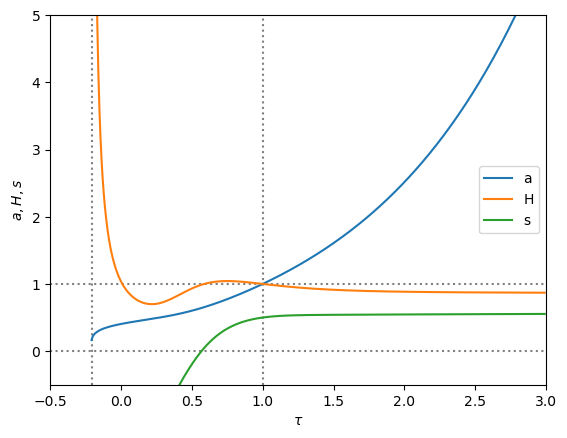

y0:  [1.  1.  0.5]
46085255.182026766

 elapsed time [sec] =  0.025650501251220703
ntr,zt[ntr],rtr:  0 0.0 0.0
rs:  1.3414204898306612e+41
R,la:  0.0 0.0


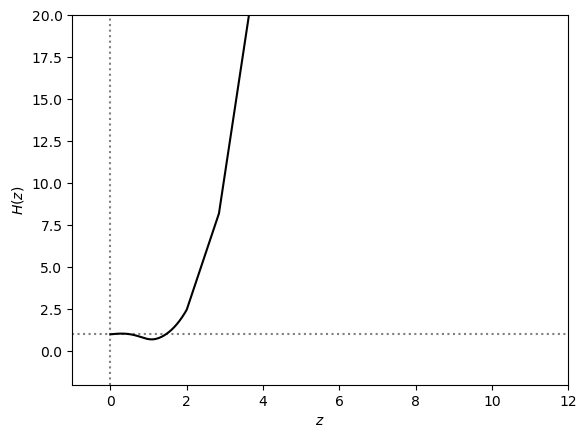

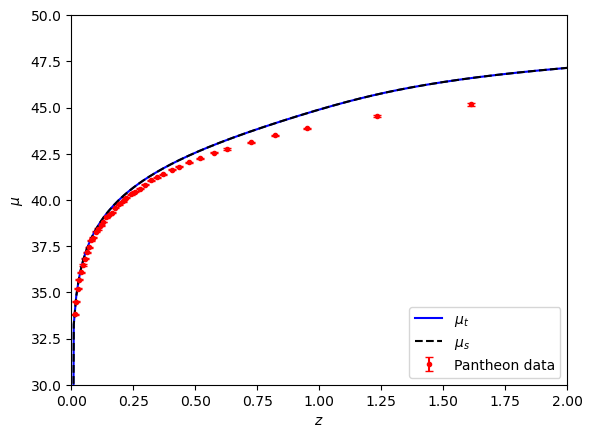

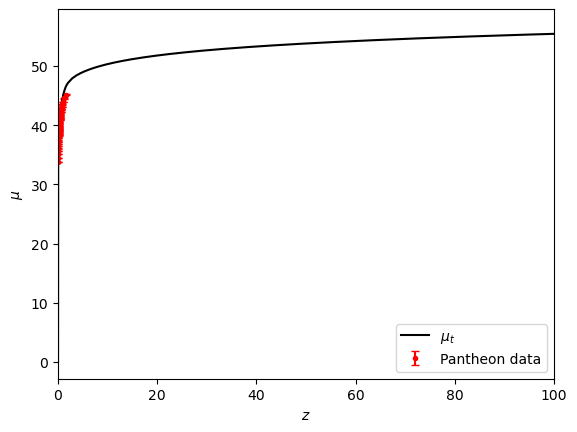

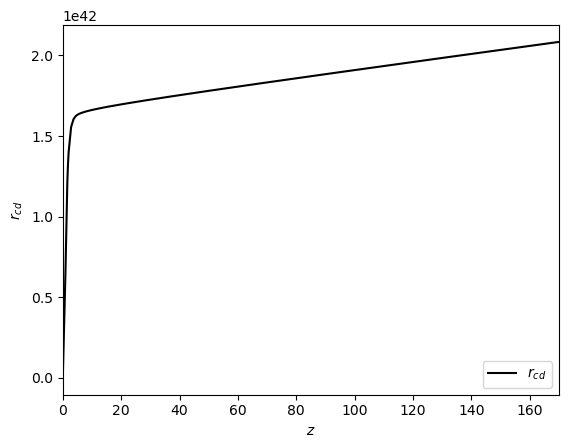

In [130]:
# H_{100} = 2.1331 * 10^{-42}  [GeV]
GR = 'n'
GR_asym = 'n'
if GR_asym == 'n':
    #          Om,    Orad,    Ol,     Ok,    h,     Os      Og     s1
    #args  = (0.315, 5.44e-5, 0.685,  0.000, 0.674, 0.500, -1.000, 0.500)
    args  = (0.315, 5.44e-5, 1.013,  0.000, 0.674, 2.700, -1.000, 0.500)
else:
    #          Om,    Orad,    Ol,     Ok,    h,     Os
    args1 = (0.315, 5.44e-5, 0.000,  0.000, 0.674, 0.900)
    Ol_GR = 0.685
    Og    = Ol_GR*(3-5*args1[5])/(1-args1[5])**2/2  # Og
    s1    = np.sqrt(2*Ol_GR/(1-args1[5]))           # s1
    args  = (args1+(Og,s1))
print("args: ",args)

AX, y0, y, yp, zs, di, mus, zt, Hz, rcd, mut = prepare_solving()
test_aHs(GR, AX, y0, yp, *args)
print("y0: ",y0)
starttime = time.time()
HBBN = calc_mus(GR, AX, y0, y, yp, zt, Hz, zs, di, mus, *args)
print(HBBN)
elapsedtime = time.time()-starttime
print('\n elapsed time [sec] = ', elapsedtime)

R,la,err = calc_R_la(zt, Hz, rcd, mut, *args)
print("R,la: ",R,la)

# plot H(z)
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.set_xlim(zt[0], zt[-1])
ax.set_xlim(-1., 12.)
ax.set_ylim(-2.e0, 2.e1)
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
ax.axhline(1,color="grey", ls='dotted', zorder=-1)
ax.axvline(0,color="grey", ls='dotted', zorder=-1)
ax.plot(zt, Hz,'k')
plt.show()

# plot mus, mut, pantheon
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0, 2)
ax.set_ylim(30, 50)
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(zt, mut, color='b',label='$\mu_t$')
plt.plot(zs, mus, color='k',ls='dashed',label='$\mu_s$')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(zt[0], zt[-1])
ax.set_xlim(zt[0], 100)
#ax.set_xlim(zt[0], 0.1)
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(zt, mut, color='k',label='$\mu_t$')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend(loc='lower right')
plt.show()

# rcd
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(zt[0], zt[-1])
plt.plot(zt, rcd, color='k',label='$r_{cd}$')
plt.xlabel('$z$')
plt.ylabel('$r_{cd}$')
plt.legend(loc='lower right')
plt.show()

#ns = len(zs)
#z  = zs[1:ns]
#mu = mus[1:ns]
nt = len(zt)
z  = zt[1:nt]
mu = mut[1:nt]

# Interpolation

In [131]:
from scipy import interpolate

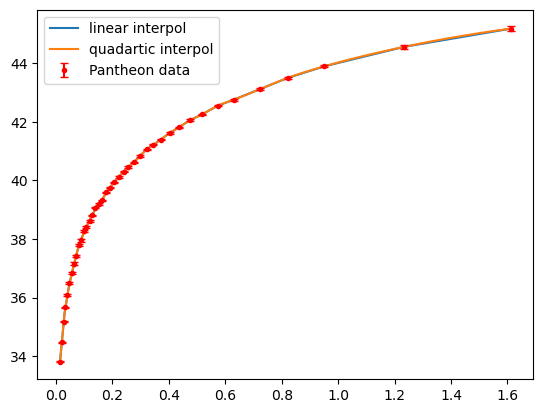

In [132]:
#Test
f1 = interpolate.interp1d(redshift, distmod, kind = 'linear')
f2 = interpolate.interp1d(redshift, distmod, kind = 'quadratic')

x_int = np.linspace(0.0140,1.6123,100)
plt.figure()
plt.plot(x_int, f1(x_int),label='linear interpol')
plt.plot(x_int, f2(x_int),label='quadartic interpol')
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.legend()
plt.show()

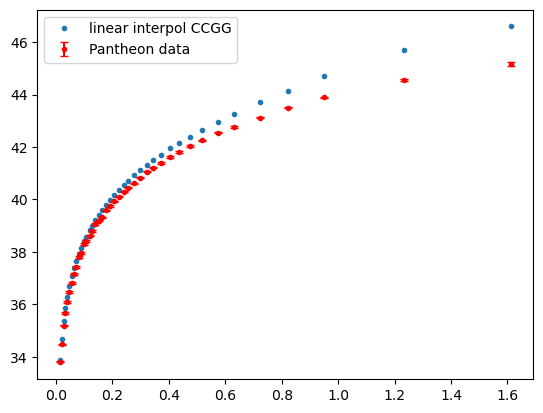

In [133]:
#Interpolate the 200 numerically computed values
f = interpolate.interp1d(z, mu, kind = 'linear')
#print(f(redshift))

#plot values of the interpolation function vs real data
mu_theo = f(redshift)
plt.figure()
plt.plot(redshift, mu_theo,'.',label='linear interpol CCGG')
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.legend()
plt.show()

# MCMC

In [134]:
#Set parameter vals for known:
Oradiation = 5.44e-5

In [135]:
# Define the log_likelihood functions
def log_likelihood_SNe(params):
    Om, Ok, Os = params
    #Omn = ((Om-0.31)/0.01)
    args = (Om, Oradiation, 1.013,  Ok, 0.674, Os, -1.000, 0.500) #1.013->0
    #AX, y0, y, yp, nz, z, Hz, di, mu, zt, rcd, mu_s = prepare_solving()
    calc_mus(GR, AX, y0, y, yp, z, Hz, zs, di, mu, *args)
    f = interpolate.interp1d(z, mu, kind = 'quadratic')
    return -0.5*np.sum(((distmod.values - f(redshift))/distmod_unc.values)**2 + np.log(2*np.pi*distmod_unc**2))

def log_likelihood_CC(params):
    Om, Ok, Os = params
    args = (Om, Oradiation, 1.013,  Ok, 0.674, Os, -1.000, 0.500)
    calc_mus(GR, AX, y0, y, yp, z, Hz, zs, di, mu, *args)
    #_,_,_,y = calc_aHs(GR, AX, y0, yp, *args) #y[1] is H, y[0] is a
    #z_st = (1/y[0]) - 1
    #print(len(zt),len(Hz))
    f = interpolate.interp1d(zt, Hz*67.4, kind = 'quadratic') #check the Hz*67.4
    #x = np.linspace(0,2,1000)
    #plt.figure()
    #plt.plot(x,f(x))
    #plt.show()
    return -0.5*np.sum(((Hub - f(redshift_CC))/Hub_unc)**2 + np.log(2*np.pi*Hub_unc**2))

def log_likelihood_BBN(params):
    Om, Ok, Os = params
    args = (Om, Oradiation, 1.013,  Ok, 0.674, Os, -1.000, 0.500)
    HBBN_theo = calc_mus(GR, AX, y0, y, yp, z, Hz, zs, di, mu, *args) #HBBN_theo obtained by extrapolation
    return -0.5*((HLCDM - HBBN_theo*67.4)/HLCDM)**2 #check the HBBN_theo*67.4

#def log_likelihood_CMB(params):
#    Om, Ok, Os = params
#    args = (Om, Oradiation, 1.013,  Ok, 0.674, Os, -1.000, 0.500)
#    #calc_mus(GR, AX, y0, y, yp, zt, Hz, zs, di, mu, *args)
#    R_theo,la_theo,err = calc_R_la(zt, Hz, rcd, mut, *args, prc=1.e-10) # check arguments... mu or mut?, rcd? do we need to run calc_mus before??
#    v_theo = np.array([R_theo,la_theo])
#    return -0.5*np.matmul((v_theo-v_obs).transpose(),np.matmul(C_inv,v_theo-v_obs))

In [136]:
Ommin = 0.3
Ommax = 0.4
Okmin = -0.01
Okmax = 0.01
Osmin = 0.2
Osmax = 0.8 #around 0.5, try Omega_l = 0.685

# Uniform log_prior
def log_prior(params):
    Om, Ok, Os = params
    if Ommin <= Om <= Ommax and Okmin <= Ok <= Okmax and Osmin <= Os <= Osmax:
        return -np.log((Ommax - Ommin)*(Okmax - Okmin)*(Osmax - Osmin))
    return -np.inf

In [137]:
#Product, resp. sum in logarithm form of likelihood and prior
def log_sum(params):
    # Compute the log-prior
    lp = log_prior(params)
    if lp == -np.inf:
        # If the prior is zero (i.e. log is -infinity), return negative infinity
        return -np.inf
    
    # Compute the log-likelihood
    lSNe = log_likelihood_SNe(params)
    lCC = log_likelihood_CC(params)
    lBB = log_likelihood_BBN(params)
    #lCMB = log_likelihood_CMB(params)
    #lBAO = ......
    
    # Compute the log-posterior as the sum of the log-prior and log-likelihood
    return lp + lSNe + lCC + lBB 

In [138]:
# Set the number of dimensions (i.e. the number of parameters)
ndim = 3

# Set the number of walkers
nwalkers = 9

# Define the range of values for each parameter
theta_min = [Ommin, Okmin, Osmin]
theta_max = [Ommax, Okmax, Osmax]

# Generate random starting positions for the walkers within the defined range
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:, i] = np.random.uniform(theta_min[i], theta_max[i], size=nwalkers)

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_sum, args=())

In [139]:
# Run the sampler for a specified number of iterations
n_iterations = 1000
sampler.run_mcmc(p0, n_iterations, progress=True)

C:\Users\armin\AppData\Local\Temp\ipykernel_16084\3368669914.py:45: RuntimeWarning: invalid value encountered in log10
  mus[i] = 5*np.log10((1+zs[i])*mus[i]/1.5637382e38)+25
100%|██████████| 1000/1000 [09:07<00:00,  1.83it/s]


State([[ 0.30169103 -0.0082428   0.79975786]
 [ 0.30112213 -0.00971799  0.79995139]
 [ 0.30000982 -0.00692064  0.79984304]
 [ 0.3000727  -0.00913943  0.79996618]
 [ 0.30004999 -0.00866315  0.7999772 ]
 [ 0.3013131  -0.00859397  0.79895576]
 [ 0.30000317 -0.00819642  0.79982738]
 [ 0.30087014 -0.00859267  0.79987281]
 [ 0.30020969 -0.0090939   0.79987367]], log_prob=[-3542.37853006 -3539.63365804 -3541.27010478 -3538.86662989
 -3539.22459865 -3544.77409052 -3540.17667912 -3540.65613968
 -3539.43078234], blobs=None, random_state=('MT19937', array([3149991516, 4021474779, 3374564777, 2797177562, 2124590531,
       2493969325,  397693531, 1094659290, 1787709815, 3799866808,
       2539894592, 3606361142, 1391680599,  135127575, 2393243644,
       2590372866, 3869143177, 1912491360, 1388726760,  317942507,
         14762966,  199100149, 3224442754, 3083001249, 4117549726,
       1352884965, 3042201547, 2460496593, 2988641035, 1529099016,
        248145737, 3701072915,  626165806, 4107597574

In [140]:
# Get the chain of samples produced by the sampler
#samples = sampler.chain[:, :, :].reshape((-1, ndim))
samples = sampler.chain[:, :, :]
print(sampler.chain[:,:,:].shape)

# Discard the first few samples as burn-in
burnin = 100
final_samples = samples[:,burnin:, :]
print(final_samples.shape)

(9, 1000, 3)
(9, 900, 3)


(8100, 3)


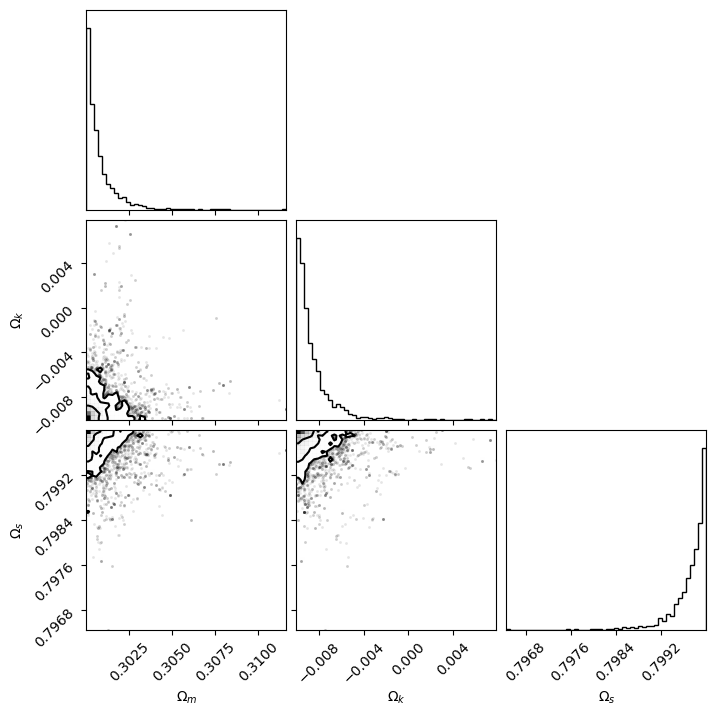

In [141]:
# Flatten the chain of samples
flat_samples = final_samples.reshape(-1, ndim)
print(flat_samples.shape)

# Plot the corner plot using the flattened samples
figure = corner.corner(flat_samples,bins=50, labels=['$\Omega_m$','$\Omega_k$','$\Omega_s$'])

# Show the plot
plt.show()

Removed no burn in


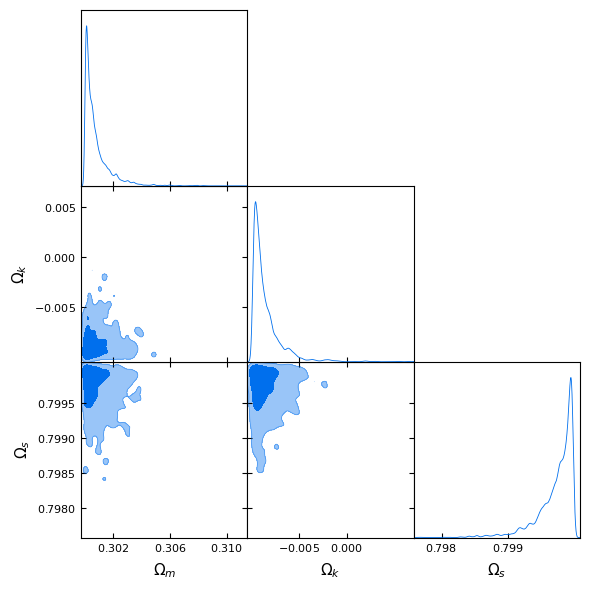

In [142]:
names = ['Omega_m','Omega_k','Omega_s']
labels =  ['\Omega_m','\Omega_k','\Omega_s']
samples_new = MCSamples(samples=np.array(flat_samples),names=names,labels=labels)
g = plots.get_subplot_plotter()
g.triangle_plot(samples_new, filled=True)

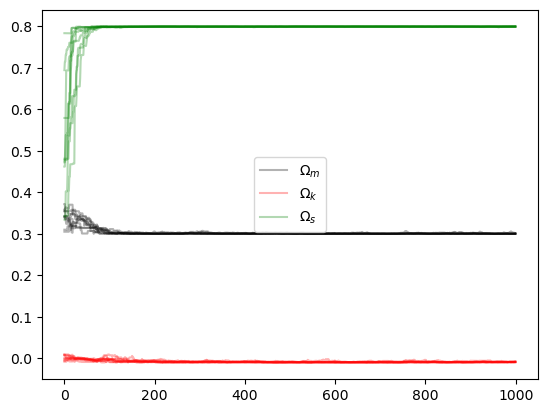

In [143]:
plt.figure()
plt.plot(samples[0,:,0].T, '-', color='k', alpha=0.3,label='$\Omega_m$')
plt.plot(samples[1:,:,0].T, '-', color='k', alpha=0.3)
plt.plot(samples[0,:,1].T, '-', color='r', alpha=0.3,label='$\Omega_k$')
plt.plot(samples[1:,:,1].T, '-', color='r', alpha=0.3)
plt.plot(samples[0,:,2].T, '-', color='g', alpha=0.3,label='$\Omega_s$')
plt.plot(samples[1:,:,2].T, '-', color='g', alpha=0.3)
plt.legend()
plt.show()

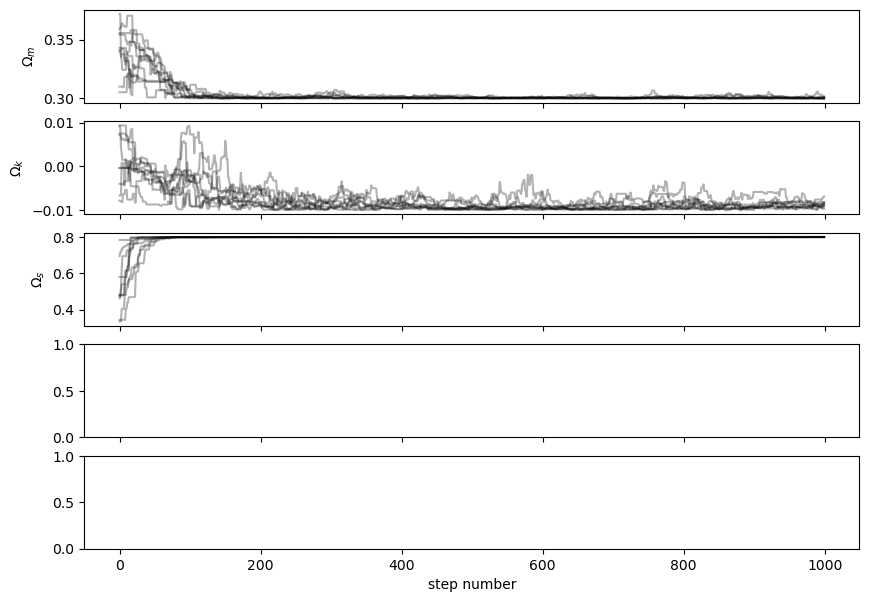

In [144]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$\Omega_m$", "$\Omega_k$", "$\Omega_s$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.chain[:,:,i].T, "k-", alpha=0.3)
    #ax.set_xlim(0, 10000)
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

In [145]:
sampler.chain[:,:,0].T.shape

(1000, 9)

In [146]:
#mean and std dev of Om_m
m1 = np.mean(flat_samples[:,0])
std1 = np.std(flat_samples[:,0])
print('Mean of Om_m = ',m1)
print('Std dev of Om_m = ',std1)

#mean and std dev of Om_k
m2 = np.mean(flat_samples[:,1])
std2 = np.std(flat_samples[:,1])
print('Mean of Om_k = ',m2)
print('Std dev of Om_k = ',std2)

#mean and std dev of Om_s
m3 = np.mean(flat_samples[:,2])
std3 = np.std(flat_samples[:,2])
print('Mean of Om_s = ',m3)
print('Std dev of Om_s = ',std3)

Mean of Om_m =  0.30081005721816245
Std dev of Om_m =  0.0010385102274673014
Mean of Om_k =  -0.008562463919187717
Std dev of Om_k =  0.0017370267240611166
Mean of Om_s =  0.7997310707200874
Std dev of Om_s =  0.00029831528419749313


0.30081005721816245 -0.008562463919187717 0.7997310707200874


C:\Users\armin\AppData\Local\Temp\ipykernel_16084\3368669914.py:45: RuntimeWarning: invalid value encountered in log10
  mus[i] = 5*np.log10((1+zs[i])*mus[i]/1.5637382e38)+25


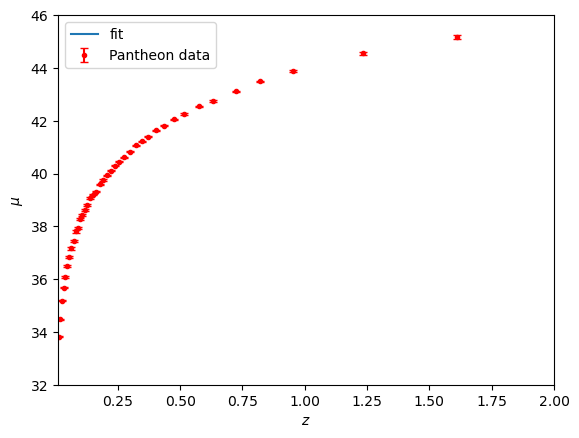

In [147]:
#Best fit
#args  = (0.315, 5.44e-5, 1.013,  0.000, 0.674, 2.700, -1.000, 0.500)
print(m1,m2,m3)
#args = (0.315, Oradiation, 0.685,  0, 0.674, 0.5,-1.000, 0.500)
args  = (m1, 5.44e-5, 1.013,  m2, 0.674, m3, -1.000, 0.500)
#AX, y0, y, yp, nz, z, Hz, di, mu, zt, rcd, mu_s = prepare_solving()
calc_mus(GR, AX, y0, y, yp, zt, Hz, zs, di, mu, *args)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0.01, 2)
ax.set_ylim(32, 46)
plt.errorbar(redshift, distmod, yerr=distmod_unc, capsize=3, fmt='r.', label='Pantheon data')
plt.plot(z,mu,label='fit')
plt.xlabel('$z$')
plt.ylabel('$\mu$')
plt.legend()
plt.show()

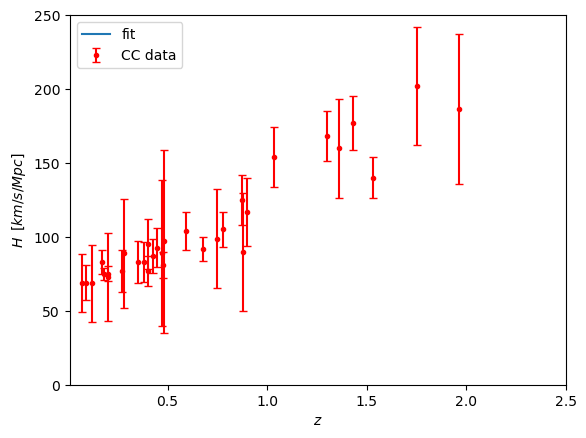

In [148]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(0.01, 2.5)
ax.set_ylim(0, 250)
plt.errorbar(redshift_CC, Hub, yerr=Hub_unc, capsize=3, fmt='r.', label='CC data')
plt.plot(zt,Hz*67.4,label='fit')
plt.xlabel('$z$')
plt.ylabel('$H\,\,\,[km/s/Mpc]$')
plt.legend()
plt.show()

In [149]:
HBBN_theo = calc_mus(GR, AX, y0, y, yp, zt, Hz, zs, di, mu, *args)
print(HBBN_theo*67.4)
print(HLCDM)
print(HLCDM/HBBN_theo*67.4)

497324.0216716291
4.76589971472913e+17
4353366747761502.0


C:\Users\armin\AppData\Local\Temp\ipykernel_16084\3368669914.py:45: RuntimeWarning: invalid value encountered in log10
  mus[i] = 5*np.log10((1+zs[i])*mus[i]/1.5637382e38)+25
